In [1]:
#https://github.com/asad70/reddit-sentiment-analysis/blob/master/reddit-sentiment-analysis.py

import praw
from data import *
import time
import pandas as pd
import matplotlib.pyplot as plt
import squarify
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from credentials import credentials

client_id, client_secret,password, user_agent, username = credentials

reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    password=password,
    user_agent=user_agent,
    username=username,
)
print(reddit.user.me())

JustAnotherCogg


In [2]:
import sqlite3
connection = sqlite3.connect("MSC.db")
cursor = connection.cursor()

connection = sqlite3.connect('MSC.db')
cursor = connection.cursor()
sql = ("Select symbol from SP500_companies")
df = pd.read_sql_query(sql,connection)

In [3]:
us = df['Symbol'].to_list() + ['CRL']

In [4]:
'''############################################################################'''
# set the program parameters
subs = ['wallstreetbets' ]     # sub-reddit to search
post_flairs = {'Daily Discussion', 'Weekend Discussion', 'Discussion'}    # posts flairs to search || None flair is automatically considered
goodAuth = {'AutoModerator'}   # authors whom comments are allowed more than once
uniqueCmt = True                # allow one comment per author per symbol
ignoreAuthP = {'example'}       # authors to ignore for posts 
ignoreAuthC = {'example'}       # authors to ignore for comment 
upvoteRatio = 0.70         # upvote ratio for post to be considered, 0.70 = 70%
ups = 20       # define # of upvotes, post is considered if upvotes exceed this #
limit = 500     # define the limit, comments 'replace more' limit
upvotes = 2     # define # of upvotes, comment is considered if upvotes exceed this #
picks = 10     # define # of picks here, prints as "Top ## picks are:"
picks_ayz = 5   # define # of picks for sentiment analysis
'''############################################################################'''

'############################################################################'

In [5]:
posts, count, c_analyzed, tickers, titles, a_comments = 0, 0, 0, {}, [], {}
cmt_auth = {}

for sub in subs:
    subreddit = reddit.subreddit(sub)
    hot_python = subreddit.hot()    # sorting posts by hot
    # Extracting comments, symbols from subreddit
    for submission in hot_python:
        flair = submission.link_flair_text 
        author = submission.author.name         
        
        # checking: post upvote ratio # of upvotes, post flair, and author 
        if submission.upvote_ratio >= upvoteRatio and submission.ups > ups and (flair in post_flairs or flair is None) and author not in ignoreAuthP:   
            submission.comment_sort = 'new'     
            comments = submission.comments
            titles.append(submission.title)
            posts += 1
            try: 
                submission.comments.replace_more(limit=limit)   
                for comment in comments:
                    # try except for deleted account?
                    try: auth = comment.author.name
                    except: pass
                    c_analyzed += 1
                    
                    # checking: comment upvotes and author
                    if comment.score > upvotes and auth not in ignoreAuthC:      
                        split = comment.body.split(" ")
                        for word in split:
                            word = word.replace("$", "")        
                            # upper = ticker, length of ticker <= 5, excluded words,                     
                            if word.isupper() and len(word) <= 5 and word not in blacklist and word in us:
                                
                                # unique comments, try/except for key errors
                                if uniqueCmt and auth not in goodAuth:
                                    try: 
                                        if auth in cmt_auth[word]: break
                                    except: pass
                                    
                                # counting tickers
                                if word in tickers:
                                    tickers[word] += 1
                                    a_comments[word].append(comment.body)
                                    cmt_auth[word].append(auth)
                                    count += 1
                                else:                               
                                    tickers[word] = 1
                                    cmt_auth[word] = [auth]
                                    a_comments[word] = [comment.body]
                                    count += 1   
            except Exception as e: print(e)
                
# sorts the dictionary
symbols = dict(sorted(tickers.items(), key=lambda item: item[1], reverse = True))

In [6]:
pd.DataFrame.from_dict(symbols, orient='index').to_csv("WB_20210522.csv")

In [ ]:
pd.DataFrame(data=today).set_index(pd.Index([i for i in range(0, len(symbols))]))

In [ ]:
pd.DataFrame.from_dict(symbols, orient='index').reset_index(inplace=True)

In [7]:
# sorts the dictionary
#symbols = dict(sorted(tickers.items(), key=lambda item: item[1], reverse = True))
top_picks = list(symbols.keys())[0:picks]

# print top picks
print("analyze {c} comments in {p} posts in {s} subreddits.\n".format(c=c_analyzed, p=posts, s=len(subs)))
print("Posts analyzed saved in titles")
#for i in titles: print(i)  # prints the title of the posts analyzed

print(f"\n{picks} most mentioned picks: ")
times = []
top = []
for i in top_picks:
    print(f"{i}: {symbols[i]}")
    times.append(symbols[i])
    top.append(f"{i}: {symbols[i]}")
   
    
# Applying Sentiment Analysis
scores, s = {}, {}
 
vader = SentimentIntensityAnalyzer()
# adding custom words from data.py 
vader.lexicon.update(new_words)

picks_sentiment = list(symbols.keys())[0:picks_ayz]


for symbol in picks_sentiment:
    stock_comments = a_comments[symbol]
    for cmnt in stock_comments:
        score = vader.polarity_scores(cmnt)
        if symbol in s:
            s[symbol][cmnt] = score
        else:
            s[symbol] = {cmnt:score}      
        if symbol in scores:
            for key, _ in score.items():
                scores[symbol][key] += score[key]
        else:
            scores[symbol] = score
            
    # calculating avg.
    for key in score:
        scores[symbol][key] = scores[symbol][key] / symbols[symbol]
        scores[symbol][key]  = "{pol:.3f}".format(pol=scores[symbol][key])

analyze 11010 comments in 11 posts in 1 subreddits.

Posts analyzed saved in titles

10 most mentioned picks: 
TSLA: 117
F: 55
NVDA: 48
AAPL: 35
AMD: 34
VIAC: 27
T: 10
BA: 9
AMZN: 8
FB: 4



Sentiment analysis of top 5 picks:
     Bearish Neutral Bullish Total/Compound
TSLA   0.120   0.715   0.165          0.052
F      0.164   0.611   0.188          0.104
NVDA   0.097   0.728   0.175          0.149
AAPL   0.146   0.658   0.196          0.199
AMD    0.071   0.668   0.261          0.337


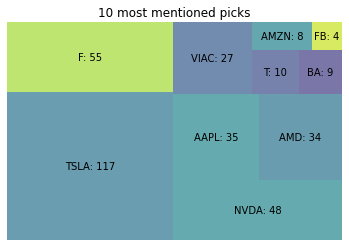

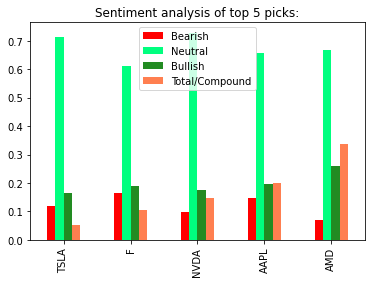

In [8]:
# printing sentiment analysis 
print(f"\nSentiment analysis of top {picks_ayz} picks:")
df = pd.DataFrame(scores)
df.index = ['Bearish', 'Neutral', 'Bullish', 'Total/Compound']
df = df.T
print(df)

# Date Visualization
# most mentioned picks    
squarify.plot(sizes=times, label=top, alpha=.7 )
plt.axis('off')
plt.title(f"{picks} most mentioned picks")
plt.show()

# Sentiment analysis
df = df.astype(float)
colors = ['red', 'springgreen', 'forestgreen', 'coral']
df.plot(kind = 'bar', color=colors, title=f"Sentiment analysis of top {picks_ayz} picks:")
plt.show()